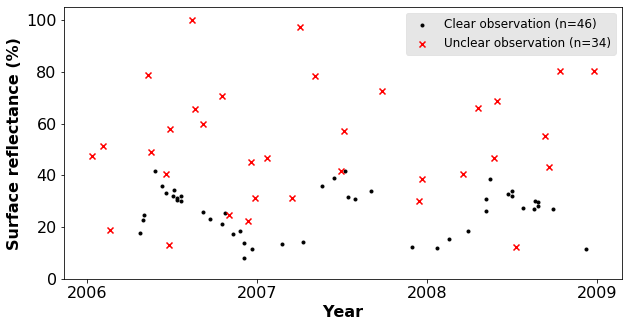

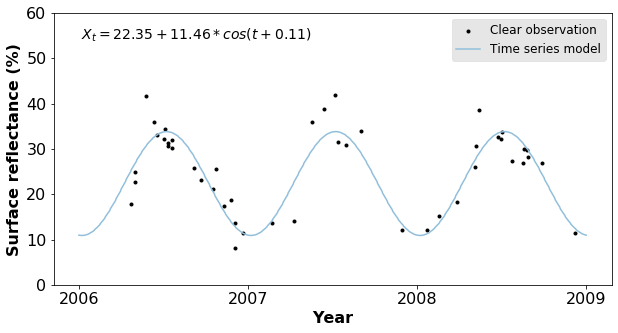

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
import numpy as np
%matplotlib inline





    
data_folder = 'data/time_series/'
output_folder = 'plots/'
refdate = dt.datetime(1970,1,1)
year = 2007

df_all = pd.read_csv(f'{data_folder}allObservations.csv',thousands=',').drop(['system:index','.geo'],axis=1)
data_all = [df_all[image][0] for image in list(df_all.columns)]

df_clear = pd.read_csv(f'{data_folder}clearObservations.csv',thousands=',').drop(['system:index','.geo'],axis=1)
data_clear = [df_clear[image][0] for image in list(df_clear.columns)]

df_time = pd.read_csv(f'{data_folder}time.csv',thousands=',').drop(['system:index','.geo'],axis=1)
data_time = [df_time[image][0] for image in list(df_time.columns)]

df_coefficients = pd.read_csv(f'{data_folder}coefficients.csv',thousands=',')


time_labels = [year-1,year,year+1,year+2]
time_ticks = [(dt.datetime(year,1,1)-refdate).total_seconds()*1000 for year in time_labels]


x_clear, y_clear, x_unclear, y_unclear = ([],[],[],[])
for i, (a,c,t) in enumerate(zip(data_all,data_clear,data_time)):
    if not math.isnan(a):
        if not math.isnan(c):
            y_clear.append(c)
            x_clear.append(t)
        else:
            a = 10000 if a>10000 else a
            y_unclear.append(a)
            x_unclear.append(t)





time = [refdate+dt.timedelta(milliseconds=timedelta) for timedelta in data_time]


fig, ax = plt.subplots(figsize=(10, 5))
fontsize = 16
plt.rcParams.update({'font.size': fontsize})
        
ax.scatter(x_clear,y_clear,marker='.',color='k')
ax.scatter(x_unclear,y_unclear,marker='x',color='r')

ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels,fontdict={'fontsize': fontsize})

y_ticks = list(np.arange(0,10001,2000))
y_labels = [f'{y_tick/100:.0f}' for y_tick in y_ticks]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontdict={'fontsize': fontsize})

ax.set_ylabel('Surface reflectance (%)',fontsize=fontsize,fontweight='bold')
ax.set_xlabel('Year',fontsize=fontsize,fontweight='bold')

ax.legend(
    [
        f'Clear observation (n={len(x_clear)})',
        f'Unclear observation (n={len(x_unclear)})'
    ],
    frameon=True,
    facecolor='#E0E0E0',
    edgecolor='#E0E0E0',
    prop={'size': 12},
    ncol=1,
    loc='upper right'
)


plt.savefig('model_observations.png',dpi=300,box_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
fontsize = 16


x_ticks = list(np.linspace(time_ticks[0],time_ticks[-1],1000))

def date_to_value(timedelta,const,ccos,csin):
    
    date = refdate+dt.timedelta(milliseconds=timedelta)
    diff = (date-refdate).days/365.24
    date = diff*2*math.pi
    
    """
    a = ccos
    b = csin
    amplitude = np.sqrt(np.power(a,2)+np.power(b,2))
    phase_shift = np.arctan(b/a)
    return const + amplitude*math.cos(date+phase_shift)
    """
    return const + ccos*math.cos(date) + csin*math.sin(date)



const = df_coefficients['constant'][0]
ccos = df_coefficients['cos_1'][0]
csin = df_coefficients['sin_1'][0]

y_values = [date_to_value(timedelta,const,ccos,csin) for timedelta in x_ticks]

ax.scatter(x_clear,y_clear,marker='.',color='k',label='Clear observation')
ax.plot(x_ticks,y_values,'-',color='#91bfdb',linewidth=1.5,label='Time series model')

ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels,fontdict={'fontsize': fontsize})

y_ticks = list(np.arange(0,6001,1000))
y_labels = [f'{y_tick/100:.0f}' for y_tick in y_ticks]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels,fontdict={'fontsize': fontsize})

ax.set_ylabel('Surface reflectance (%)',fontsize=fontsize,fontweight='bold')
ax.set_xlabel('Year',fontsize=fontsize,fontweight='bold')


a = ccos
b = csin
amplitude = np.sqrt(np.power(a,2)+np.power(b,2))
phase_shift = np.arctan(b/a)

textstr = '\n'.join((
    r'$c=%.2f$' % (const, ),
    r'$A=%.2f$' % (amplitude, ),
    r'$p=%.2f$' % (phase_shift, )))

textstr = f'$X_t=%.2f+%.2f*cos(t+%.2f)$' % (const/100,amplitude/100,phase_shift)

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    frameon=True,
    facecolor='#E0E0E0',
    edgecolor='#E0E0E0',
    prop={'size': 12},
    ncol=1,
    loc='upper right'
)

plt.savefig(f'{output_folder}model_timeseries.png',dpi=300,box_inches='tight')
plt.show()